# Training a CNN to Identify if a door is open or closed

## Part 1: Data Collection/Preparation:

### Improvement options
- Change layer amount in ResNet
- Change training and validation data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import os

ImportError: dlopen(/Users/gage/anaconda3/lib/python3.11/site-packages/torch/_C.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/libtorch_cpu.dylib
  Referenced from: <2D6B6C8F-2E8E-3F48-B5D9-8E117F86A1D8> /Users/gage/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/Users/gage/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/lib/python3.11/site-packages/torch/lib/../../../../libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/lib/python3.11/site-packages/torch/../../../libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/lib/python3.11/site-packages/torch/../../../libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/bin/../lib/libtorch_cpu.dylib' (no such file), '/Users/gage/anaconda3/bin/../lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

Doing research into how to use pytorch to import images, I found the website below and used it to help figure out the process:
https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

I created a directory folder which contains all the data, separated into train and validation subdirectories. Since we want to determine if the door is open or closed, the train and validation directories each have open and closed subdirectores that have images of the door in open or closed position from various angles and lighting conditions.

In [2]:
script_dir = os.path.dirname(os.path.abspath(__file__))
Directory = os.path.join(script_dir, "Door")

Below we load and save the training dataset and valid dataset. A transformation is applied to standardize the data into 224x224 pixel squares.

In [3]:

transformer = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ])


train_dataset = datasets.ImageFolder(Directory + '/train', transform = transformer)
valid_dataset = datasets.ImageFolder(Directory + '/valid', transform = transformer)


In [4]:
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

I used stackoverflow to find out how to extract the features from the penultimate layer of a pretrained model. I forward propegate a test image through the model and extract the values at the final hidden layer.

https://stackoverflow.com/questions/55083642/extract-features-from-last-hidden-layer-pytorch-resnet18

To use the feature extractor, you must have a 4D tensor. We don't have a batch size with the image, so we only have a 3D tensor. We can fix this by applying unsqueeze to the images. Unsqueeze(img,0) adds an extra dimension to the tensor where the batch size would be, essentially adding a batch size of 1.

https://pytorch.org/docs/stable/generated/torch.unsqueeze.html

After extracting the features, we can use torch.squeeze() to remove all of the arrays that have a single entry. This will remove the batch dimension that we added earlier and the pixel dimensions as well. We now have a 1D tensor with just the images features and  add it to the array.

https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html

In [5]:
import torchvision.models as models

def prepare_data(model, train_dataset, valid_dataset):
    
    # Initialize the feature extractor and get feature size
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    with torch.no_grad():
        test_feature_set = feature_extractor(torch.randn(1,3,224,224))
        feature_size = np.prod(np.array(test_feature_set.shape)[1:])
        
    num_train_samples = len(train_dataset)
    num_valid_samples = len(valid_dataset)  

    # Pre-allocate arrays for features and labels
    training_features = np.zeros((num_train_samples, feature_size))
    training_labels = np.zeros(num_train_samples)
    valid_features = np.zeros((num_valid_samples, feature_size))
    valid_labels = np.zeros(num_valid_samples)

    # Extract features and labels for training set
    for i, (images, labels) in enumerate(train_dataset):
        with torch.no_grad():
            # remove everything except features
            output = feature_extractor(images.unsqueeze(0))
            output = torch.squeeze(output)
        # Convert the output tensor into a numpy array
        training_features[i] = output.numpy()
        training_labels[i] = labels

    # Extract features and labels for validation set
    for i, (images, labels) in enumerate(valid_dataset):
        with torch.no_grad():
            output = feature_extractor(images.unsqueeze(0))
            output = torch.squeeze(output)
        valid_features[i] = output.numpy()
        valid_labels[i] = labels
        
    return training_features, training_labels, valid_features, valid_labels

In [6]:
def plot_losses(train_loss, val_loss):
    # Number of epochs can be calculated as the length of one of these lists
    num_epochs = len(train_loss)

    # Plotting
    plt.plot(range(num_epochs), train_loss, label='Train Loss')
    plt.plot(range(num_epochs), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
import torch.nn as nn

def train_cnn(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, lr):
    
    # Replace the fully connected layer to adapt model
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Change the output layer to match number of classes
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.fc.parameters(), lr, momentum=0.9)
    
    # Training loop
    num_epochs = 5
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for i, (images, labels) in enumerate(train_dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        train_losses.append(epoch_train_loss / len(train_dataloader))
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        epoch_valid_loss = 0
        with torch.no_grad():
            for images, labels in valid_dataloader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        valid_losses.append(epoch_valid_loss / len(valid_dataloader))
        print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total}')
        
    return train_losses, valid_losses

In [8]:
model = models.resnet18(pretrained=True)
train_losses, valid_losses = train_cnn(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 0.01)

/Users/gage/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gage/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Accuracy: 98.03921568627452
Epoch 2, Accuracy: 88.23529411764706
Epoch 3, Accuracy: 100.0
Epoch 4, Accuracy: 98.03921568627452
Epoch 5, Accuracy: 100.0


KeyboardInterrupt: 

In [9]:
plot_losses(train_losses, valid_losses)

NameError: name 'train_losses' is not defined

In the graph, our training data loss keeps decreasing, but our validation loss plataus and begins to creep up. It looks like the beginning of overfitting towards epoch 6 and onwards. I think we would need to get more data before we could see much improvement over this model. We will try a larger resnet model and see if more layers will help improve accuracy.

In [15]:
model = models.resnet34(pretrained=True)
train_losses, valid_losses = train_cnn(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 0.01)

/Users/gage/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Accuracy: 42.5
Epoch 2, Accuracy: 62.5
Epoch 3, Accuracy: 70.0
Epoch 4, Accuracy: 60.0
Epoch 5, Accuracy: 65.0
Epoch 6, Accuracy: 85.0
Epoch 7, Accuracy: 80.0
Epoch 8, Accuracy: 85.0
Epoch 9, Accuracy: 77.5
Epoch 10, Accuracy: 85.0


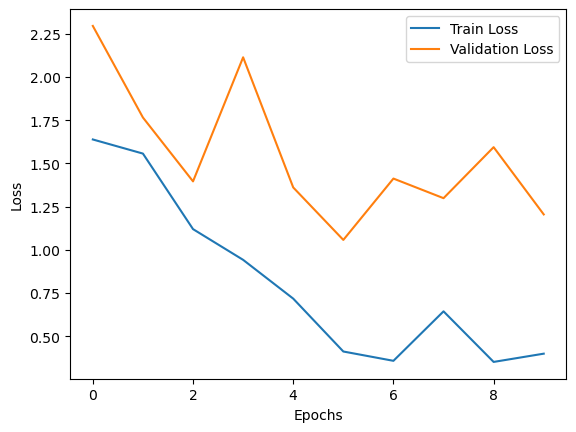

In [16]:
plot_losses(train_losses, valid_losses)

It didn't help much with loss, and we see overfitting again with no improvement in accuracy. Its probably better to use simpler models since we have a very small dataset. Learning too much on small data can quickly lead to overfitting and recognizing patterns that only apply to the few datapoints in the set. I would throw this out and keep the 18 layer resnet. We will try a lower learning rate, but I don't think we will see much improvement without better data. We already tried selecting images that were representative of the entire dataset for validation and I don't think we can do much else.

In [17]:
model = models.resnet18(pretrained=True)
train_losses, valid_losses = train_cnn(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 0.005)

Epoch 1, Accuracy: 57.5
Epoch 2, Accuracy: 70.0
Epoch 3, Accuracy: 65.0
Epoch 4, Accuracy: 75.0
Epoch 5, Accuracy: 80.0
Epoch 6, Accuracy: 75.0
Epoch 7, Accuracy: 77.5
Epoch 8, Accuracy: 77.5
Epoch 9, Accuracy: 77.5
Epoch 10, Accuracy: 80.0


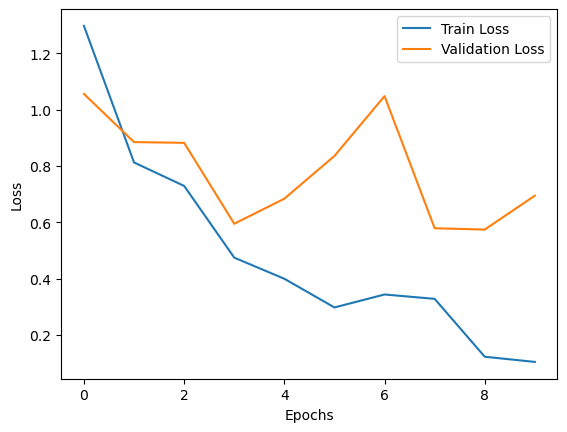

In [18]:
plot_losses(train_losses, valid_losses)